This notebooks purpose is to compare different metrics that I found interesting while investigating the data from the 3 countries individually. Therefore the reasoning for final verdict/recommendation can be understood by having a look at this notebook.

### Import Statements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os , math
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
# setting seaborn as the default style
sns.set_theme() 

### Define Constants

In [3]:
DATA_FOLDER = "../data/external"
BENIN_MALANVILLE_PATH = os.path.join(DATA_FOLDER , 'benin-malanville.csv')
SIERRALEONE_BUMBUNA_PATH = os.path.join(DATA_FOLDER , 'sierraleone-bumbuna.csv')
TOGO_DAPAONG_PATH = os.path.join(DATA_FOLDER , 'togo-dapaong_qc.csv')

### Load the data

In [4]:
bennin_df = pd.read_csv(BENIN_MALANVILLE_PATH)
sierraleone_df = pd.read_csv(SIERRALEONE_BUMBUNA_PATH)
togo_df = pd.read_csv(TOGO_DAPAONG_PATH)

In [5]:
# categorical columns
CATAGORGICAL_COLS = ["Timestamp" , "Cleaning"]

# quantitative columns
QUANTITATIVE_COLS = [col for col in bennin_df.columns if col not in CATAGORGICAL_COLS]

# target columns
TARGET_COLUMNS = ["ModA" , "ModB"]

### 1) Data cleaning & Prep

The data cleaning and prep for all the documents is pretty much the same. So instead of looking at the other notebooks to see what is done , here is a small recap:
* Remove the **Comments** column because it contains no data
* Clip the negative readings of **DHI**, **GNI** and **GHI** to zero
* Remove outliers
* Then add new columns called 'Hour' and 'Month' by decomposing the 'Timestamp' column

In [6]:
# remove the 'Comments' column from all of the dataframes
bennin_df = bennin_df.drop(columns=['Comments'])
sierraleone_df = sierraleone_df.drop(columns=['Comments'])
togo_df = togo_df.drop(columns=['Comments'])

# clip the negative readings of 'DHI', 'DNI' and 'GHI' to zero
bennin_df[['GHI' , 'DNI' , 'DHI']] = bennin_df[['GHI' , 'DNI' , 'DHI']].clip(lower=0)
sierraleone_df[['GHI' , 'DNI' , 'DHI']] = sierraleone_df[['GHI' , 'DNI' , 'DHI']].clip(lower=0)
togo_df[['GHI' , 'DNI' , 'DHI']] = togo_df[['GHI' , 'DNI' , 'DHI']].clip(lower=0)

In [7]:
# remove outliers
# the upper-limit z-score allowed for all data
THRESHOLD = 3

# create mask for filtering data points based on z-score threshold
bennin_zscore_mask = np.abs(stats.zscore(bennin_df.drop(columns=CATAGORGICAL_COLS)) < THRESHOLD).all(axis = 1)
sierraleone_zscore_mask = np.abs(stats.zscore(sierraleone_df.drop(columns=CATAGORGICAL_COLS)) < THRESHOLD).all(axis = 1)
togo_zscore_mask = np.abs(stats.zscore(togo_df.drop(columns=CATAGORGICAL_COLS)) < THRESHOLD).all(axis = 1)

# apply mask to the dataframes
bennin_df_filtered = bennin_df[bennin_zscore_mask]
sierraleone_df_filtered = sierraleone_df[sierraleone_zscore_mask]
togo_df_filtered = togo_df[togo_zscore_mask]

From the other 3 notebooks I know that I will use the hours and month that can be obtained from the 'Timestamp' column, so let us decompose the column to new column 'Hour' and 'Month'

In [8]:
# breakdown the timestamp into hours of the day and also month of the year
bennin_df['Timestamp'] = pd.to_datetime(bennin_df['Timestamp'])
bennin_df['Hour'] = bennin_df['Timestamp'].dt.hour
bennin_df['Month'] = bennin_df['Timestamp'].dt.month

sierraleone_df['Timestamp'] = pd.to_datetime(sierraleone_df['Timestamp'])
sierraleone_df['Hour'] = sierraleone_df['Timestamp'].dt.hour
sierraleone_df['Month'] = sierraleone_df['Timestamp'].dt.month

togo_df['Timestamp'] = pd.to_datetime(togo_df['Timestamp'])
togo_df['Hour'] = togo_df['Timestamp'].dt.hour
togo_df['Month'] = togo_df['Timestamp'].dt.month

### 2) Comparison between countries

From the independent analysis I did on the 3 other notebooks. I have decided to measure the efficiency to be gained from the solar panels from the reading of **ModA** and **ModB**. And also to help compare the advantages disadvantages of the three regions have over eachother by investigating the features that have high correlation with the above mentioned measurements. 

* Line plot with intersectional shadding that visualizes the difference in ModA and ModB readings between the three countries.

**Note**: For the ease of analysis I decided to take the average of ModA and ModB readings because from the analysis of the datas in the separate notebooks it is clear to see that both ModA and ModB have almost the same readings are correlated to each other with a coefficient of 0.99 therefor squashing them into one measurement won't bring that much difference in the analysis

In [9]:
# take average of ModA and ModB
bennin_df['ModAverage'] = bennin_df[['ModA' , 'ModB']].mean(axis=1)
sierraleone_df['ModAverage'] = sierraleone_df[['ModA' , 'ModB']].mean(axis=1)
togo_df['ModAverage'] = togo_df[['ModA' , 'ModB']].mean(axis=1)

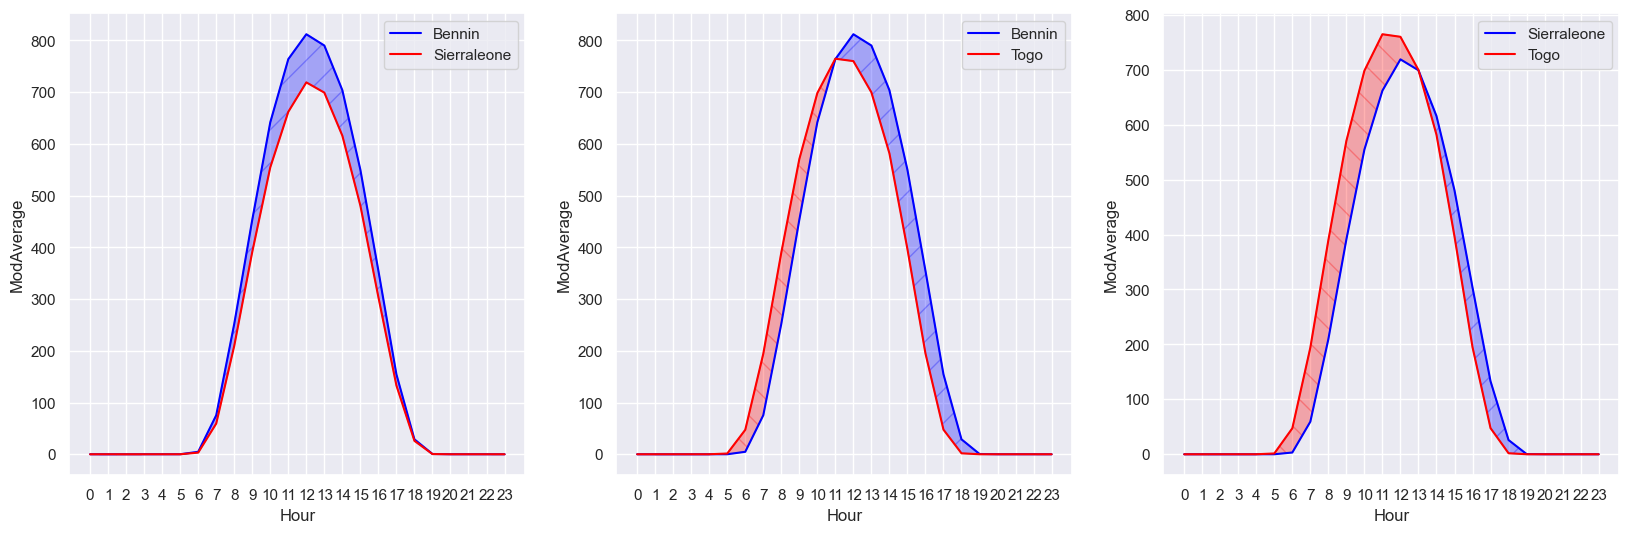

In [10]:
# the difference in ModA between Bennin , Sierraleone and Togo
fig , ax = plt.subplots(ncols=3 , nrows=1 , sharex=True ,  figsize=(20, 6) , squeeze=True)

# Bennin vs Sierraleone
data1 = bennin_df.groupby(['Hour'])['ModAverage'].mean().reset_index()
data2 = sierraleone_df.groupby(['Hour'])['ModAverage'].mean().reset_index()
sns.lineplot(data=data1 , x='Hour' , y='ModAverage' , ax=ax[0] , label='Bennin' , color='blue')
sns.lineplot(data=data2 ,  x='Hour' , y='ModAverage' , ax=ax[0] , label='Sierraleone' , color='red')
ax[0].fill_between(data1['Hour'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] <= data1['ModAverage']), interpolate=True, color='blue', alpha=0.3, hatch='/')
ax[0].fill_between(data2['Hour'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] > data1['ModAverage']), interpolate=True, color='red', alpha=0.3, hatch='\\')


# Benning vs Togo
data1 = bennin_df.groupby(['Hour'])['ModAverage'].mean().reset_index()
data2 = togo_df.groupby(['Hour'])['ModAverage'].mean().reset_index()
sns.lineplot(data=data1 , x='Hour' , y='ModAverage' , ax=ax[1] , label='Bennin' , color='blue')
sns.lineplot(data=data2 ,  x='Hour' , y='ModAverage' , ax=ax[1] , label='Togo' , color='red')
ax[1].fill_between(data1['Hour'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] <= data1['ModAverage']), interpolate=True, color='blue', alpha=0.3, hatch='/')
ax[1].fill_between(data2['Hour'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] > data1['ModAverage']), interpolate=True, color='red', alpha=0.3, hatch='\\')

# Sierraleone vs Togo
data1 = sierraleone_df.groupby(['Hour'])['ModAverage'].mean().reset_index()
data2 = togo_df.groupby(['Hour'])['ModAverage'].mean().reset_index()
sns.lineplot(data=data1 , x='Hour' , y='ModAverage' , ax=ax[2] , label='Sierraleone' , color='blue')
sns.lineplot(data=data2 ,  x='Hour' , y='ModAverage' , ax=ax[2] , label='Togo' , color='red')
ax[2].fill_between(data1['Hour'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] <= data1['ModAverage']), interpolate=True, color='blue', alpha=0.3, hatch='/')
ax[2].fill_between(data2['Hour'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] > data1['ModAverage']), interpolate=True, color='red', alpha=0.3, hatch='\\')

# Customize the x-axis to increment by 1
plt.xticks(ticks=range(bennin_df['Hour'].min(), bennin_df['Hour'].max() + 1, 1))

plt.legend()
plt.show()

* It is clear to see that Bennin gets more W/m<sup>2</sup> in a day more than Sierraleone and Togo
* We can also notice that Togo gets more W/m<sup>2</sup> than Sierraleone

Hence the order for Wattage per area received in a day is:
1) Bennin
2) Togo
3) Sierraleone

We can show the size of the shaded areas numerically as follows:

In [11]:
# difference between bennin and sierraleone
ben_sier_dif = (bennin_df.groupby('Hour')['ModAverage'].mean() - sierraleone_df.groupby('Hour')['ModAverage'].mean()).sum()

# difference between bennin and togo
ben_tog_dif = (bennin_df.groupby('Hour')['ModAverage'].mean() - togo_df.groupby('Hour')['ModAverage'].mean()).sum()

# difference between togo and sierraleone
tog_sier_dif = (togo_df.groupby('Hour')['ModAverage'].mean() - sierraleone_df.groupby('Hour')['ModAverage'].mean()).sum()

In [12]:
print(f"Bennin - Seirraleone => {ben_sier_dif}")
print(f"Bennin - Toggo => {ben_tog_dif}")
print(f"Togo - Sierraleone => {tog_sier_dif}")

Bennin - Seirraleone => 728.5834292237444
Bennin - Toggo => 237.12131278538823
Togo - Sierraleone => 491.46211643835625


* We can do the same thing but this time for the months of the year

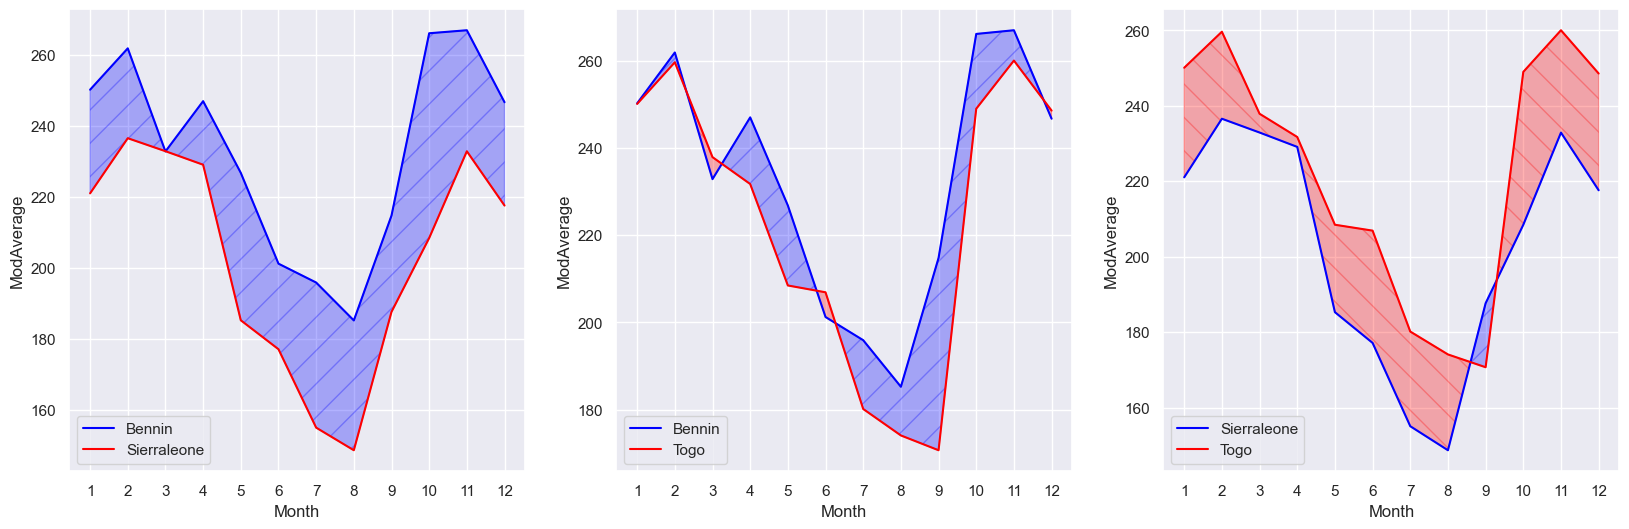

In [13]:
# the difference in ModA between Bennin , Sierraleone and Togo
fig , ax = plt.subplots(ncols=3 , nrows=1 , sharex=True ,  figsize=(20, 6) , squeeze=True)

# Bennin vs Sierraleone
data1 = bennin_df.groupby(['Month'])['ModAverage'].mean().reset_index()
data2 = sierraleone_df.groupby(['Month'])['ModAverage'].mean().reset_index()
sns.lineplot(data=data1 , x='Month' , y='ModAverage' , ax=ax[0] , label='Bennin' , color='blue')
sns.lineplot(data=data2 ,  x='Month' , y='ModAverage' , ax=ax[0] , label='Sierraleone' , color='red')
ax[0].fill_between(data1['Month'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] <= data1['ModAverage']), interpolate=True, color='blue', alpha=0.3, hatch='/')
ax[0].fill_between(data2['Month'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] > data1['ModAverage']), interpolate=True, color='red', alpha=0.3, hatch='\\')


# Benning vs Togo
data1 = bennin_df.groupby(['Month'])['ModAverage'].mean().reset_index()
data2 = togo_df.groupby(['Month'])['ModAverage'].mean().reset_index()
sns.lineplot(data=data1 , x='Month' , y='ModAverage' , ax=ax[1] , label='Bennin' , color='blue')
sns.lineplot(data=data2 ,  x='Month' , y='ModAverage' , ax=ax[1] , label='Togo' , color='red')
ax[1].fill_between(data1['Month'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] <= data1['ModAverage']), interpolate=True, color='blue', alpha=0.3, hatch='/')
ax[1].fill_between(data2['Month'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] > data1['ModAverage']), interpolate=True, color='red', alpha=0.3, hatch='\\')

# Sierraleone vs Togo
data1 = sierraleone_df.groupby(['Month'])['ModAverage'].mean().reset_index()
data2 = togo_df.groupby(['Month'])['ModAverage'].mean().reset_index()
sns.lineplot(data=data1 , x='Month' , y='ModAverage' , ax=ax[2] , label='Sierraleone' , color='blue')
sns.lineplot(data=data2 ,  x='Month' , y='ModAverage' , ax=ax[2] , label='Togo' , color='red')
ax[2].fill_between(data1['Month'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] <= data1['ModAverage']), interpolate=True, color='blue', alpha=0.3, hatch='/')
ax[2].fill_between(data2['Month'], data1['ModAverage'], data2['ModAverage'], where=(data2['ModAverage'] > data1['ModAverage']), interpolate=True, color='red', alpha=0.3, hatch='\\')

# Customize the x-axis to increment by 1
plt.xticks(ticks=range(bennin_df['Month'].min(), bennin_df['Month'].max() + 1, 1))

plt.legend()
plt.show()

In [14]:
# difference between bennin and sierraleone
ben_sier_dif = (bennin_df.groupby('Month')['ModAverage'].mean() - sierraleone_df.groupby('Month')['ModAverage'].mean()).sum()

# difference between bennin and togo
ben_tog_dif = (bennin_df.groupby('Month')['ModAverage'].mean() - togo_df.groupby('Month')['ModAverage'].mean()).sum()

# difference between togo and sierraleone
tog_sier_dif = (togo_df.groupby('Month')['ModAverage'].mean() - sierraleone_df.groupby('Month')['ModAverage'].mean()).sum()

In [15]:
print(f"Bennin - Seirraleone => {ben_sier_dif}")
print(f"Bennin - Toggo => {ben_tog_dif}")
print(f"Togo - Sierraleone => {tog_sier_dif}")

Bennin - Seirraleone => 363.2130924645843
Bennin - Toggo => 118.50258266129032
Togo - Sierraleone => 244.71050980329397


From the plot above we can also see the rankings:
1) Bennin
2) Togo
3) Sierraleone

Before making our final decision let us first see how the standard deviation for each of the datas behaves

In [16]:
bennin_sd = bennin_df.groupby('Month')['ModAverage'].std().mean()
sierraleone_sd = sierraleone_df.groupby('Month')['ModAverage'].std().mean()
togo_sd = togo_df.groupby('Month')['ModAverage'].std().mean()

In [17]:
print(f"Standard Deviation of Bennin's Watts per metter square obtain in the months : {bennin_sd}")
print(f"Standard Deviation of Sierraleone's Watts per metter square obtain in the months : {sierraleone_sd}")
print(f"Standard Deviation of Togo's Watts per metter square obtain in the months : {togo_sd}")

Standard Deviation of Bennin's Watts per metter square obtain in the months : 319.4597873537712
Standard Deviation of Sierraleone's Watts per metter square obtain in the months : 291.73628138036605
Standard Deviation of Togo's Watts per metter square obtain in the months : 309.3682994268526


So now we can conclude that even though Bennin has a bit more higher variation in its readings (infered from the standard deviation) the difference in the mean with the rest of the countries is big to ignore. So thus far in the analysis Bennin looks like the best place to build a solar farm.

* Now let us investigate what type of irradiation is found in all of the countries through out the months of the year

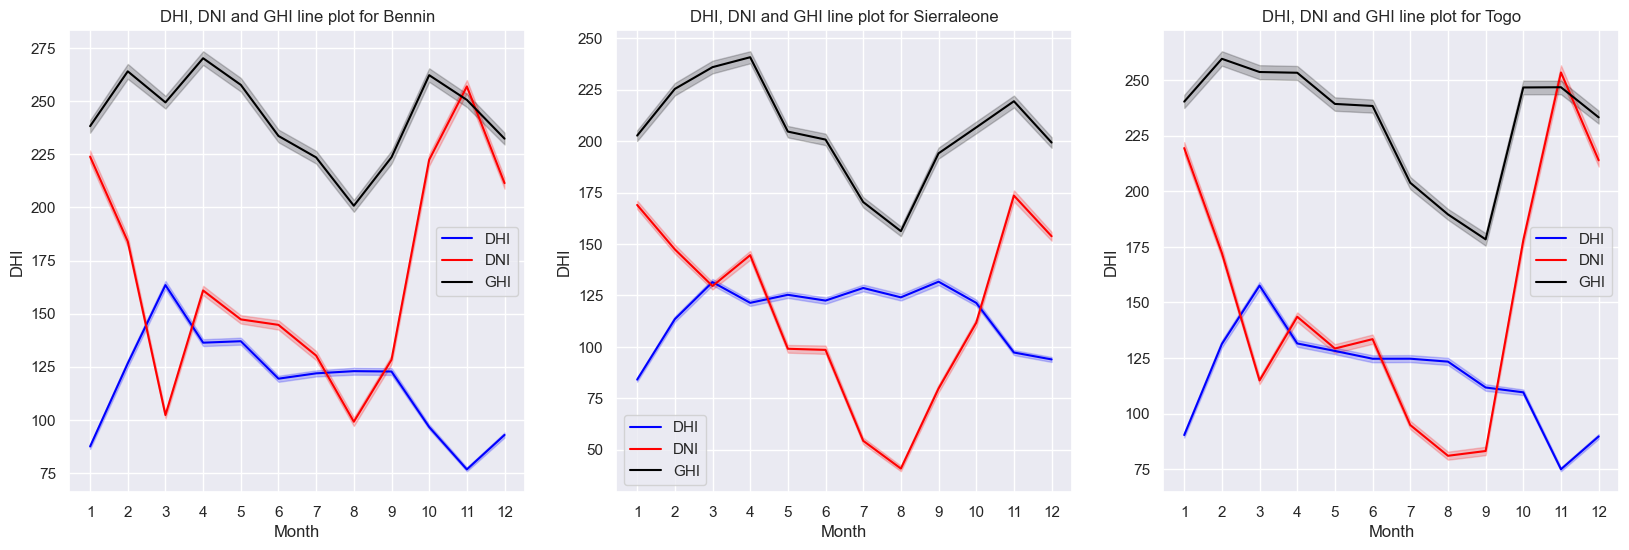

In [18]:
# the difference in ModA between Bennin , Sierraleone and Togo
fig , ax = plt.subplots(ncols=3 , nrows=1 , sharex=True ,  figsize=(20, 6) , squeeze=True)

# DHI, DNI and GHI line plot for Bennin
sns.lineplot(data=bennin_df , x='Month' , y='DHI' , ax=ax[0] , label='DHI' , color='blue')
sns.lineplot(data=bennin_df ,  x='Month' , y='DNI' , ax=ax[0] , label='DNI' , color='red')
sns.lineplot(data=bennin_df ,  x='Month' , y='GHI' , ax=ax[0] , label='GHI' , color='black')
ax[0].set_title("DHI, DNI and GHI line plot for Bennin")

# DHI, DNI and GHI line plot for sierraleone
sns.lineplot(data=sierraleone_df , x='Month' , y='DHI' , ax=ax[1] , label='DHI' , color='blue')
sns.lineplot(data=sierraleone_df ,  x='Month' , y='DNI' , ax=ax[1] , label='DNI' , color='red')
sns.lineplot(data=sierraleone_df ,  x='Month' , y='GHI' , ax=ax[1] , label='GHI' , color='black')
ax[1].set_title("DHI, DNI and GHI line plot for Sierraleone")

# DHI, DNI and GHI line plot for togo
sns.lineplot(data=togo_df , x='Month' , y='DHI' , ax=ax[2] , label='DHI' , color='blue')
sns.lineplot(data=togo_df ,  x='Month' , y='DNI' , ax=ax[2] , label='DNI' , color='red')
sns.lineplot(data=togo_df ,  x='Month' , y='GHI' , ax=ax[2] , label='GHI' , color='black')
ax[2].set_title("DHI, DNI and GHI line plot for Togo")

# Customize the x-axis to increment by 1
plt.xticks(ticks=range(bennin_df['Month'].min(), bennin_df['Month'].max() + 1, 1))

plt.legend()
plt.show()

This shows us that all countries have the same patern for GHI measurement but the values obtained from Bennin are higher than the other two. And also if we look at the DNI measurements we can see that Bennin and Togo have very similar paterns with Bennin's measurement being a bit higher than Togo's. They also have a very similar DHI measurement patterns which is quite low compared to their DNI and GHI measurements. This is an indication that most of the radiation they obtain comes from direct impact of the solar rays with the modules. When we look at the DHI measurement of Sierraleone how ever it has some what a high value all year round and its DNI is below the DHI for most of the year this shows that Sierraleone has cloud coverage for most of the months of the year.

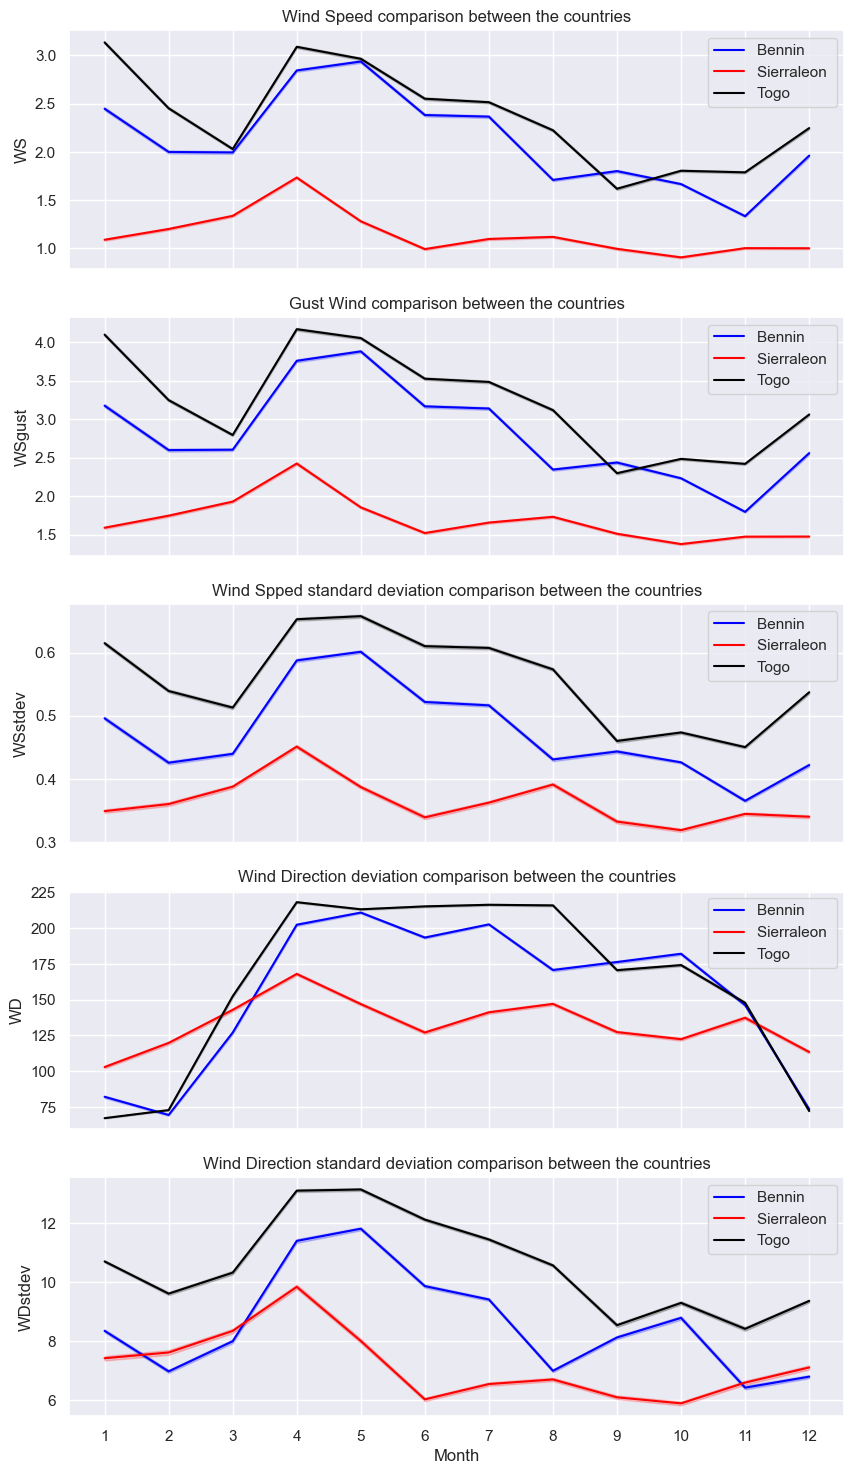

In [19]:
# the difference in ModA between Bennin , Sierraleone and Togo
fig , ax = plt.subplots(ncols=1, nrows=5 , sharex=True ,  figsize=(10, 18) , squeeze=True)

# WS
sns.lineplot(data=bennin_df , x='Month' , y='WS' , label='Bennin ' , color='blue' , ax=ax[0])
sns.lineplot(data=sierraleone_df , x='Month' , y='WS' , label='Sierraleon ' , color='red', ax=ax[0])
sns.lineplot(data=togo_df , x='Month' , y='WS' , label='Togo ' , color='black', ax=ax[0])
ax[0].set_title("Wind Speed comparison between the countries")

# WSgust
sns.lineplot(data=bennin_df , x='Month' , y='WSgust' , label='Bennin ' , color='blue' , ax=ax[1])
sns.lineplot(data=sierraleone_df , x='Month' , y='WSgust' , label='Sierraleon ' , color='red', ax=ax[1])
sns.lineplot(data=togo_df , x='Month' , y='WSgust' , label='Togo ' , color='black', ax=ax[1])
ax[1].set_title("Gust Wind comparison between the countries")

# WSstdev
sns.lineplot(data=bennin_df , x='Month' , y='WSstdev' , label='Bennin ' , color='blue' , ax=ax[2])
sns.lineplot(data=sierraleone_df , x='Month' , y='WSstdev' , label='Sierraleon ' , color='red', ax=ax[2])
sns.lineplot(data=togo_df , x='Month' , y='WSstdev' , label='Togo ' , color='black', ax=ax[2])
ax[2].set_title("Wind Spped standard deviation comparison between the countries")

# WD
sns.lineplot(data=bennin_df , x='Month' , y='WD' , label='Bennin ' , color='blue' , ax=ax[3])
sns.lineplot(data=sierraleone_df , x='Month' , y='WD' , label='Sierraleon ' , color='red', ax=ax[3])
sns.lineplot(data=togo_df , x='Month' , y='WD' , label='Togo ' , color='black', ax=ax[3])
ax[3].set_title("Wind Direction deviation comparison between the countries")

# WDstdev
sns.lineplot(data=bennin_df , x='Month' , y='WDstdev' , label='Bennin ' , color='blue' , ax=ax[4])
sns.lineplot(data=sierraleone_df , x='Month' , y='WDstdev' , label='Sierraleon ' , color='red', ax=ax[4])
sns.lineplot(data=togo_df , x='Month' , y='WDstdev' , label='Togo ' , color='black', ax=ax[4])
ax[4].set_title("Wind Direction standard deviation comparison between the countries")

# Customize the x-axis to increment by 1
plt.xticks(ticks=range(bennin_df['Month'].min(), bennin_df['Month'].max() + 1, 1))

plt.legend()
plt.show()

The reason we are conserned about the wind speed , direction and standard deviation is because it plays a crucial role in the efficiency of solar panels. The wind helps cool down the surface of the solar panels which in return means their efficiency increases. So what we want to have is a wind speed that isn't so high it will cause strucural damage and also has a consistent direction through out seasons so that we don't have to move/reorient our panels frequently.

Having this in mind we can see that:
* Bennin & Togo have wind speeds near 3km/hr for most of the year
* The direction of the wind has two phases and stays consistent though those phases, which makes it ideal to avoid reorientation every now and then
* Their gust speed is high compared to Sierraleon's but it is at most 4km/hr

### 3) Final Recommendation

After all of the analysis my recommendation is to choose **Bennin** for investing into solar. The reasons that lead to this recommendation are:
* Bennin has a higher measuring of irradiation recieved in hours of the day and also months of the year.
* Most of the irradiation that Bennin recieves is from Direct Normal Irradiation and Global Horizontal Irradiation, which are critical factors that determine the amount of power a solar panel can harness. Especially Direct Normal Irradiation with a sun tracking system achieve the highest solar efficiency.
* For most of the months in a year Diffused Solar Irradiation is low. This indicates that even though there is a wet season in Bennin the cloud coverage is very minimal which exposes the solar panels to direct sun light.
* The wind speed , direction and variation are moderate enough where they help cool the solar panels but also don't have the potential to cause structural damange on the solar panels.